In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import useful_functions as uf
import density as den
import constants as cc
from scipy.interpolate import interp1d
import sys
sys.path.insert(0,'/home/zahra/hirax_tools/hirax_tools')
from array_config import HIRAXArrayConfig
from scipy.integrate import trapz
import pylab
from matplotlib.colors import LogNorm

In [2]:
cosmo=uf.cosmo

Mps_interpf=uf.Mps_interpf

n_points=40
n=n_points
z_r=10

x_e=1.

G=cc.G_const_Mpc_Msun_s/cc.M_sun_g

#rho_c=3*H0**2/(8.*np.pi*G)

rho_c=den.cosmo_densities(**cosmo)[0]*cc.M_sun_g #in units of g/Mpc^3

sigma_T=cc.sigma_T_Mpc

tau_r=0.055

T_rad=2.725 #In Kelvin
#tau_r=0.046*omega_b_0*h*x_e[np.sqrt(omega_M_0(1+z_r)**3+(1-omega_M_0))-1]

#get matter power spec data

mu_e=1.14

m_p=cc.m_p_g #in grams

rho_g0=cosmo['omega_b_0']*rho_c

#plt.loglog(uf.kabs,Mps_interpf(uf.kabs))

#plt.show()
zed=uf.zed

H=uf.H
chi=uf.chi
#chi_Z=chi(Z)
tau_inst=uf.tau_inst
f=uf.f
D=uf.D_1
r=uf.r
z_c=1.26
delta_z=0.2

kperp_lims=uf.ell_lims(z_c,6.,1024*6.)/uf.chi(z_c)
kpar_min_lim=uf.kpar_min(z_c,delta_z)

#kpperp_min=kperp_lims[0]
#kpperp_max=kperp_lims[1]
kpperp_min=5.e-4
kpperp_max=20.
kppar_min=1.e-3
kppar_max=1.

In [3]:
ell=np.geomspace(2.,1.e4,n_points)
kperp_arr=ell/chi(z_c)
kpar_arr=np.geomspace(kppar_min,kppar_max,n_points)
y=kpar_arr*r(z_c)

print (kperp_arr.max())

1.7217043803820464


In [4]:

#kpar_min=uf.kpar_min(z,delta_z)

def ionized_elec(Yp,N_He):

    x=(1-Yp*(1-N_He/4))/(1-Yp/2)

    return x


x=ionized_elec(0.24,0)


In [5]:
loaded_fourier_arr=np.load('nu_and_kpar_fourier_dchi2_int_full_redshift_10000pts.npy')

nu=loaded_fourier_arr[0,:]
f_of_kpar_func=loaded_fourier_arr[1,:]

kpar_fourier_dchi2_int=interp1d(nu,f_of_kpar_func)

def crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    T_mean_zi=uf.T_mean(z)
    chi_zi=chi(z)
    f_zi=uf.f(z)
    D_zi=uf.D_1(z)
    r_zi=uf.r(z)
    H_zi=uf.H(z)
    kpar=y/uf.r(z)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    kp=np.sqrt(kp_perp**2+kp_par**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par#*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K_perp=np.sqrt(np.abs(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp))
    #theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_K=(np.abs(kpar-kp_par))/K
    theta_kp=cos_theta
    z_integral=np.abs(kpar_fourier_dchi2_int(kpar))
    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2*kp_perp/kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp_perp/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)



In [6]:
def Func_2d_redshift(ell,z_arr,y,Func,delta_z):
    Func_mat=np.zeros((len(ell),len(y),len(z_arr)))
    for i in range(len(ell)):
        for j in range(len(y)):
            for z_ind in range(len(z_arr)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z)
                Func_mat[i][j][z_ind]=Func_ind
    return Func_mat


def Func_noise_redshift_slow(ell,z_arr,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y),len(z_arr)))
    for i in range(len(ell)):
        for j in range(len(y)):
            for z_ind in range(len(z_arr)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z,Noise)
                Func_mat[i][j][z_ind]=Func_ind       
    return Func_mat

def Func_noise_redshift_fast(ell,z_arr,y,Func,delta_z,Noise):
    Func_mat=[Func(ell[i],z_arr[z_ind],y[j],delta_z,Noise) 
        for i in range(len(ell))
        for j in range(len(y))
        for z_ind in range(len(z_arr))]
    return Func_mat


def Func_2d(ell,z_c,y,Func,delta_z):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z_c,y[j],delta_z)
            Func_mat[i][j]=Func_ind
    return Func_mat


def Func_noise(ell,z_c,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z_c,y[j],delta_z,Noise)
            Func_mat[i][j]=Func_ind
    return Func_mat


def Signal_integrated_fourier(ell,z,y,delta_z):
    Kp_perp=np.geomspace(kpperp_min,kpperp_max,n)
    Kp_par=np.geomspace(kppar_min,kppar_max,n)
    kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    B=crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par)
    integral=trapz(trapz(B,Kp_perp,axis=0),Kp_par,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral


In [7]:
Cl_ksz=np.load('C_l_ksz_z_1_full_100pts_2d_2_1e5.npy')
ell_loaded=Cl_ksz[0,:]
Cl_ksz_full_arr=Cl_ksz[1,:]
OV_interp=interp1d(ell_loaded,Cl_ksz_full_arr)

In [8]:

ell_large=np.geomspace(2.,1.e5,50000)
#np.save('cmb_spec_2_1e5_50000pts',(ell_large,cmb_spec(ell_large)))
#np.save('cmb_noise_2_1e5_50000pts',(ell_large,cmb_noise(ell_large)))
cmb_spec=np.load('cmb_spec_2_1e5_50000pts.npy')
cmb_noise=np.load('cmb_noise_2_1e5_50000pts.npy')
ell_cmb=cmb_spec[0,:]
cmb_spec_loaded=cmb_spec[1,:]
cmb_noise_loaded=cmb_noise[1,:]

cmb_spec_interp=interp1d(ell_cmb,cmb_spec_loaded)
cmb_noise_interp=interp1d(ell_cmb,cmb_noise_loaded)

In [9]:
file_dish_z_2pt86=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_86.dat',dtype=float,unpack=True)
file_interferom_z_2pt86=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_86.dat',dtype=float,unpack=True)


file_dish_z_2pt76=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_76.dat',dtype=float,unpack=True)
file_interferom_z_2pt76=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_76.dat',dtype=float,unpack=True)


file_dish_z_2pt66=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_66.dat',dtype=float,unpack=True)
file_interferom_z_2pt66=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_66.dat',dtype=float,unpack=True)


file_dish_z_2pt56=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_56.dat',dtype=float,unpack=True)
file_interferom_z_2pt56=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_56.dat',dtype=float,unpack=True)


file_dish_z_2pt46=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_46.dat',dtype=float,unpack=True)
file_interferom_z_2pt46=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_46.dat',dtype=float,unpack=True)


file_dish_z_2pt36=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_36.dat',dtype=float,unpack=True)
file_interferom_z_2pt36=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_36.dat',dtype=float,unpack=True)


file_dish_z_2pt26=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_26.dat',dtype=float,unpack=True)
file_interferom_z_2pt26=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_26.dat',dtype=float,unpack=True)


file_dish_z_2pt16=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_16.dat',dtype=float,unpack=True)
file_interferom_z_2pt16=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_16.dat',dtype=float,unpack=True)


file_dish_z_2pt06=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_06.dat',dtype=float,unpack=True)
file_interferom_z_2pt06=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_06.dat',dtype=float,unpack=True)


file_dish_z_1pt96=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_96.dat',dtype=float,unpack=True)
file_interferom_z_1pt96=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_96.dat',dtype=float,unpack=True)


file_dish_z_1pt86=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_86.dat',dtype=float,unpack=True)
file_interferom_z_1pt86=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_86.dat',dtype=float,unpack=True)


file_dish_z_1pt76=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_76.dat',dtype=float,unpack=True)
file_interferom_z_1pt76=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_76.dat',dtype=float,unpack=True)


file_dish_z_1pt66=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_66.dat',dtype=float,unpack=True)
file_interferom_z_1pt66=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_66.dat',dtype=float,unpack=True)


file_dish_z_1pt56=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_56.dat',dtype=float,unpack=True)
file_interferom_z_1pt56=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_56.dat',dtype=float,unpack=True)

file_dish_z_1pt46=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_46.dat',dtype=float,unpack=True)
file_interferom_z_1pt46=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_46.dat',dtype=float,unpack=True)

file_dish_z_1pt36=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_36.dat',dtype=float,unpack=True)
file_interferom_z_1pt36=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_36.dat',dtype=float,unpack=True)

file_dish_z_1pt26=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_26.dat',dtype=float,unpack=True)
file_interferom_z_1pt26=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_26.dat',dtype=float,unpack=True)

file_dish_z_1pt16=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_16.dat', dtype=float,unpack=True)
file_interferom_z_1pt16=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_16.dat', dtype=float,unpack=True)

file_dish_z_1pt06=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_06.dat', dtype=float,unpack=True)
file_interferom_z_1pt06=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_06.dat', dtype=float,unpack=True)


file_dish_z_pt96=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_96.dat', dtype=float, unpack=True)
file_interferom_z_pt96=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_96.dat', dtype=float,unpack=True)

file_dish_z_pt86=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_86.dat', dtype=float, unpack=True)
file_interferom_z_pt86=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_86.dat', dtype=float,unpack=True)

file_dish_z_pt76=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_76.dat', dtype=float, unpack=True)
file_interferom_z_pt76=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_76.dat', dtype=float,unpack=True)

file_dish_z_pt66=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_66.dat', dtype=float, unpack=True)
file_interferom_z_pt66=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_66.dat', dtype=float,unpack=True)

file_dish_z_pt56=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_56.dat', dtype=float, unpack=True)
file_interferom_z_pt56=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_56.dat', dtype=float,unpack=True)

file_dish_z_pt46=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_46.dat', dtype=float, unpack=True)
file_interferom_z_pt46=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_46.dat', dtype=float,unpack=True)

file_dish_z_pt36=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_36.dat', dtype=float, unpack=True)
file_interferom_z_pt36=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_36.dat', dtype=float,unpack=True)

In [10]:
def SKA_dish_interferom(ell, file_dish, file_interferom):
    dish_file_loaded=file_dish
    ell_dish=dish_file_loaded[:,0]
    SKA_dish=dish_file_loaded[:,1]
    SKA_noise_dish_interp=interp1d(ell_dish, SKA_dish)
    
    interferom_file_loaded=file_interferom
    ell_interferom=interferom_file_loaded[:,0]
    SKA_interferom=interferom_file_loaded[:,1]
    SKA_noise_interferom_interp=interp1d(ell_interferom, SKA_interferom)
    
    SKA_noise_total_interp=interp1d(ell_interferom,1./(1./(1.e6*SKA_noise_dish_interp(ell_interferom))+1./(1.e6*SKA_noise_interferom_interp(ell_interferom))))
    
    return 1.e6*SKA_noise_dish_interp(ell), 1.e6*SKA_noise_interferom_interp(ell), SKA_noise_total_interp(ell)

In [11]:
SKA_func_z_2pt86=SKA_dish_interferom(ell, file_dish_z_2pt86, file_interferom_z_2pt86)
SKA_func_z_2pt76=SKA_dish_interferom(ell, file_dish_z_2pt76, file_interferom_z_2pt76)
SKA_func_z_2pt66=SKA_dish_interferom(ell, file_dish_z_2pt66, file_interferom_z_2pt66)
SKA_func_z_2pt56=SKA_dish_interferom(ell, file_dish_z_2pt56, file_interferom_z_2pt56)
SKA_func_z_2pt46=SKA_dish_interferom(ell, file_dish_z_2pt46, file_interferom_z_2pt46)
SKA_func_z_2pt36=SKA_dish_interferom(ell, file_dish_z_2pt36, file_interferom_z_2pt36)
SKA_func_z_2pt26=SKA_dish_interferom(ell, file_dish_z_2pt26, file_interferom_z_2pt26)
SKA_func_z_2pt16=SKA_dish_interferom(ell, file_dish_z_2pt16, file_interferom_z_2pt16)
SKA_func_z_2pt06=SKA_dish_interferom(ell, file_dish_z_2pt06, file_interferom_z_2pt06)
SKA_func_z_1pt96=SKA_dish_interferom(ell, file_dish_z_1pt96, file_interferom_z_1pt96)
SKA_func_z_1pt86=SKA_dish_interferom(ell, file_dish_z_1pt86, file_interferom_z_1pt86)
SKA_func_z_1pt76=SKA_dish_interferom(ell, file_dish_z_1pt76, file_interferom_z_1pt76)
SKA_func_z_1pt66=SKA_dish_interferom(ell, file_dish_z_1pt66, file_interferom_z_1pt66)
SKA_func_z_1pt56=SKA_dish_interferom(ell, file_dish_z_1pt56, file_interferom_z_1pt56)
SKA_func_z_1pt46=SKA_dish_interferom(ell, file_dish_z_1pt46, file_interferom_z_1pt46)
SKA_func_z_1pt36=SKA_dish_interferom(ell, file_dish_z_1pt36, file_interferom_z_1pt36)
SKA_func_z_1pt26=SKA_dish_interferom(ell, file_dish_z_1pt26, file_interferom_z_1pt26)
SKA_func_z_1pt16=SKA_dish_interferom(ell, file_dish_z_1pt16, file_interferom_z_1pt16)
SKA_func_z_1pt06=SKA_dish_interferom(ell, file_dish_z_1pt06, file_interferom_z_1pt06)
SKA_func_z_pt96=SKA_dish_interferom(ell, file_dish_z_pt96, file_interferom_z_pt96)
SKA_func_z_pt86=SKA_dish_interferom(ell, file_dish_z_pt86, file_interferom_z_pt86)
SKA_func_z_pt76=SKA_dish_interferom(ell, file_dish_z_pt76, file_interferom_z_pt76)
SKA_func_z_pt66=SKA_dish_interferom(ell, file_dish_z_pt66, file_interferom_z_pt66)
SKA_func_z_pt56=SKA_dish_interferom(ell, file_dish_z_pt56, file_interferom_z_pt56)
SKA_func_z_pt46=SKA_dish_interferom(ell, file_dish_z_pt46, file_interferom_z_pt46)
SKA_func_z_pt36=SKA_dish_interferom(ell, file_dish_z_pt36, file_interferom_z_pt36)


In [25]:
#SKA_dish_tot=1./(1./SKA_func_z_1pt46[0]+1./SKA_func_z_1pt36[0]+1./SKA_func_z_1pt26[0]+1./SKA_func_z_1pt16[0]+1./SKA_func_z_pt86[0])
#SKA_dish_tot=1./(1./SKA_func_z_1pt46[0]+1./SKA_func_z_1pt36[0]+1./SKA_func_z_1pt26[0]+1./SKA_func_z_1pt16[0]+1./SKA_func_z_1pt06[0]+1./SKA_func_z_pt86[0]+1./SKA_func_z_pt76[0])
SKA_dish_tot=1./(1./SKA_func_z_1pt16[0]+1./SKA_func_z_1pt06[0]+1./SKA_func_z_pt96[0]+1./SKA_func_z_pt86[0])
SKA_interferom_tot=1./(1./SKA_func_z_1pt16[1]+1./SKA_func_z_1pt06[1]+1./SKA_func_z_pt96[1]+1./SKA_func_z_pt86[1])
SKA_total_tot=1./(1./SKA_func_z_1pt16[2]+1./SKA_func_z_1pt06[2]+1./SKA_func_z_pt96[2]+1./SKA_func_z_pt86[2])
#SKA_total_tot=SKA_func_z_1pt16[2]+SKA_func_z_1pt06[2]+SKA_func_z_pt96[2]+SKA_func_z_pt86[2]
#SKA_total=1./(1./SKA_dish_tot+1./SKA_interferom_tot)

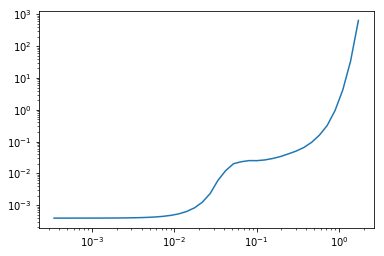

In [27]:
#plt.loglog(ell,SKA_dish_tot)
#plt.loglog(ell,SKA_interferom_tot)
plt.loglog(kperp_arr,SKA_total_tot)

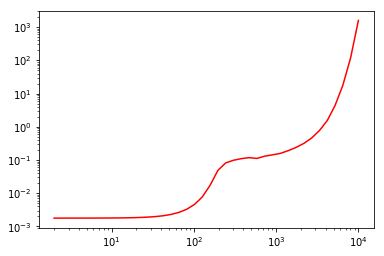

In [20]:
plt.loglog(ell,SKA_func_z_1pt26[2],'r')
#plt.loglog(ell,SKA_func_z_1pt26[0])
#plt.loglog(ell,SKA_func_z_1pt26[1])
#plt.ylim(1.e-3,1.e3)

In [ ]:
plt.loglog(ell,SKA_func_z_pt86[2])
plt.loglog(ell,SKA_func_z_pt86[0])
plt.loglog(ell,SKA_func_z_pt86[1])
plt.ylim(1.e-3,1.e3)

In [ ]:
plt.loglog(ell,SKA_func_z_1pt16[2])
plt.loglog(ell,SKA_func_z_1pt16[0])
plt.loglog(ell,SKA_func_z_1pt16[1])
plt.ylim(1.e-3,1.e3)

In [ ]:
plt.loglog(ell,1./(1./SKA_func_z_1pt26[0]+1./SKA_func_z_1pt16[0]+1./SKA_func_z_pt86[0]),'r')
#plt.loglog(ell,SKA_func_z_1pt26[0]+SKA_func_z_1pt16[0],'k')
plt.loglog(ell,SKA_func_z_1pt16[0],'g')
plt.loglog(ell,SKA_func_z_1pt26[0],'b')
plt.loglog(ell,SKA_func_z_pt86[0],'k')
plt.ylim(1.e-5,1e5)
#plt.xlim(10,1000)

In [ ]:
print ell_dish_z_1pt16.min(), ell_dish_z_1pt16.max()
print ell_dish_z_1pt26.min(), ell_dish_z_1pt26.max()

In [ ]:
plt.loglog(ell,Noise(ell))